In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
sys.path.append('../../src') # path to src directory
import absolute_abundance_functions as aa

In [2]:
# ddPCR-specific analysis portion
ddpcr_path = "input/ddpcr_data_example.xlsx" # user edit
ddpcr_sheet_name = "Sheet1" # user edit

layout_path = "input/ddpcr_layout_example.xlsx" # user edit
layout_sheet_name = "Sheet1" # user edit

format_conversion_path = "../../artifacts/format_conversion.tsv" # path to format conversion file

# Universal analysis portion
weights_path = "input/ddpcr_weights_example.xlsx" # user edit
weights_sheet_name = "Sheet1" # user edit

nist_expected_path = "../../artifacts/nist_expected_values_03262024.xlsx" # path to NIST expected file
nist_expected_sheet_name = "Sheet1" # NIST expected sheet name

In [3]:
param_dict_ddpcr = {
    "DROPLET_VOLUME": 0.795,
    "RXN_VOLUME": 22,
    "MIN_ACCEPTED_DROPLETS": 10000,
    "MAX_COPIES_RXN_LOB": 25,
    "MAX_COPIES_RXN_SPAN_NTC": 4,
    "MIN_NEGATIVE_DROPLETS": 10,
    "COPIES_RXN_LOQ_MULT": 4
}

param_dict_univ = {
    "NIST_MAX_FOLD_DIFF": 5.0,
    "NEG_EXTRACT_CTRL_MAX_COPIES": 5000.0,
    "POS_EXTRACT_CTRL_MAX_SPAN": 2,
    "EXTRACT_MAX_INPUT": 0.250,
    "EXTRACT_MIN_INPUT": 0.150,
    "DRYING_MAX_INPUT": 0.125,
    "DRYING_MIN_INPUT": 0.075,
    "MIN_DRIED_DRY_MASS": 0.008,
    "WATER_FRACTION_CUTOFF": 0.9,
}

In [4]:
aa.prepare_matplotlib()

# ddPCR-specific analysis

## Load data

In [5]:
layout96 = pd.read_excel(layout_path, sheet_name=layout_sheet_name)
ddpcr = pd.read_excel(ddpcr_path, sheet_name=ddpcr_sheet_name)

In [6]:
layout96

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume
0,A1,NIST_A,10000.0,10.0,PCRPos,6.0,NaN
1,B1,NTC_1,10000.0,1.0,PCRNeg,6.0,NaN
2,C1,NIST_L,10000.0,10.0,PCRPos,6.0,NaN
3,D1,NTC_2,10000.0,1.0,PCRNeg,6.0,NaN
4,E1,NIST_O,10000.0,10.0,PCRPos,6.0,NaN
...,...,...,...,...,...,...,...
91,D12,NaN,NaN,NaN,NaN,NaN,NaN
92,E12,NaN,NaN,NaN,NaN,NaN,NaN
93,F12,NaN,NaN,NaN,NaN,NaN,NaN
94,G12,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
ddpcr

,Well,Accepted Droplets,Positives,Negatives
0,A01,17832.0,2530.0,15302.0
1,A02,17731.0,15493.0,2238.0
2,A03,NaN,NaN,NaN
3,A04,NaN,NaN,NaN
4,A05,NaN,NaN,NaN
...,...,...,...,...
91,H08,NaN,NaN,NaN
92,H09,NaN,NaN,NaN
93,H10,NaN,NaN,NaN
94,H11,NaN,NaN,NaN


## Name unique

In [8]:
vc = layout96["Name"].value_counts()
if vc.max() > 1:
    vc = vc[vc > 1]
    raise ValueError(f"{len(vc)} sample names occur more than once: {", ".join(vc.index)}")

## Formatting

In [9]:
ddpcr2 = aa.ddpcr_formatting(layout96, ddpcr)

In [10]:
ddpcr2

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Positives,Negatives,Accepted Droplets
0,A01,NIST_A,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2530.0,15302.0,17832.0
1,B01,NTC_1,10000.0,1.0,PCRNeg,6.0,NaN,10000.0,7.0,18115.0,18122.0
2,C01,NIST_L,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2484.0,16688.0,19172.0
3,D01,NTC_2,10000.0,1.0,PCRNeg,6.0,NaN,10000.0,5.0,17707.0,17712.0
4,E01,NIST_O,10000.0,10.0,PCRPos,6.0,NaN,100000.0,3049.0,16332.0,19381.0
...,...,...,...,...,...,...,...,...,...,...,...
91,D12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,E12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,F12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,G12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate copies per reaction

In [11]:
ddpcr3 = aa.ddpcr_calculate_copies_per_reaction_as_setup(ddpcr2, param_dict_ddpcr)

In [12]:
ddpcr3

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
0,A01,NIST_A,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2530.0,15302.0,17832.0,4234.268252
1,B01,NTC_1,10000.0,1.0,PCRNeg,6.0,NaN,10000.0,7.0,18115.0,18122.0,10.691321
2,C01,NIST_L,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2484.0,16688.0,19172.0,3839.926575
3,D01,NTC_2,10000.0,1.0,PCRNeg,6.0,NaN,10000.0,5.0,17707.0,17712.0,7.813026
4,E01,NIST_O,10000.0,10.0,PCRPos,6.0,NaN,100000.0,3049.0,16332.0,19381.0,4736.692186
5,F01,NTC_3,10000.0,1.0,PCRNeg,6.0,NaN,10000.0,10.0,19437.0,19447.0,14.233596
6,G01,NIST_mix_A_R,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2854.0,15436.0,18290.0,4694.772845
7,H01,NTC_4,10000.0,1.0,PCRNeg,6.0,NaN,10000.0,8.0,18593.0,18601.0,11.904267
8,A02,my_extraction_1,10000.0,1.0,Sample,6.0,100.0,10000.0,15493.0,2238.0,17731.0,57275.600030
9,B02,my_extraction_2,10000.0,1.0,DNAPos,6.0,100.0,10000.0,3545.0,15727.0,19272.0,5625.200334


## Low number of droplets

In [13]:
ddpcr4, droplets_low = aa.check_num_of_droplets(ddpcr3, param_dict_ddpcr)

In [14]:
ddpcr4

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
0,A01,NIST_A,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2530.0,15302.0,17832.0,4234.268252
1,B01,NTC_1,10000.0,1.0,PCRNeg,6.0,NaN,10000.0,7.0,18115.0,18122.0,10.691321
2,C01,NIST_L,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2484.0,16688.0,19172.0,3839.926575
3,D01,NTC_2,10000.0,1.0,PCRNeg,6.0,NaN,10000.0,5.0,17707.0,17712.0,7.813026
4,E01,NIST_O,10000.0,10.0,PCRPos,6.0,NaN,100000.0,3049.0,16332.0,19381.0,4736.692186
5,F01,NTC_3,10000.0,1.0,PCRNeg,6.0,NaN,10000.0,10.0,19437.0,19447.0,14.233596
6,G01,NIST_mix_A_R,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2854.0,15436.0,18290.0,4694.772845
7,H01,NTC_4,10000.0,1.0,PCRNeg,6.0,NaN,10000.0,8.0,18593.0,18601.0,11.904267
8,A02,my_extraction_1,10000.0,1.0,Sample,6.0,100.0,10000.0,15493.0,2238.0,17731.0,57275.600030
9,B02,my_extraction_2,10000.0,1.0,DNAPos,6.0,100.0,10000.0,3545.0,15727.0,19272.0,5625.200334


In [15]:
droplets_low

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
13,F02,my_extraction_6,10.0,1.0,Sample,6.0,100.0,10.0,4399.0,2601.0,7000.0,27396.618336


## No template controls and LOB

In [16]:
copies_rxn_NTC_span, param_dict_ddpcr = aa.ddpcr_determine_limit_of_blank(ddpcr4, param_dict_ddpcr)

In [17]:
copies_rxn_NTC_span

1.8217776229598743

In [18]:
param_dict_ddpcr["MAX_COPIES_RXN_SPAN_NTC"]

4

In [19]:
param_dict_ddpcr["COPIES_RXN_LIMIT_OF_BLANK"]

14.233595609982926

In [20]:
param_dict_ddpcr["MAX_COPIES_RXN_LOB"]

25

## Samples and controls

In [21]:
ddpcr5 = ddpcr4[ddpcr4["Type"].isin(["PCRPos", "DNAPos", "DNANeg", "Sample"])].copy()

### Example easy seaborn plot

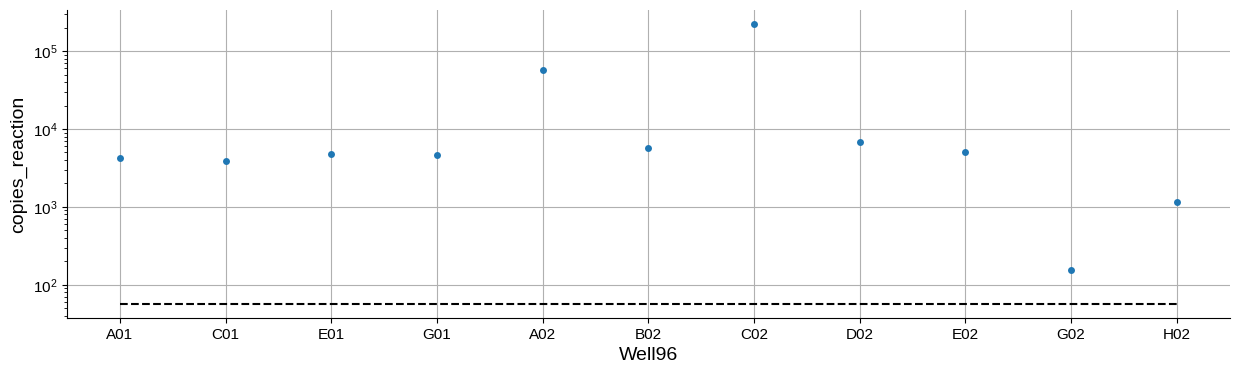

In [22]:
LOQ = param_dict_ddpcr['COPIES_RXN_LIMIT_OF_BLANK'] * param_dict_ddpcr['COPIES_RXN_LOQ_MULT'] # e.g. limit of quantification

fig, ax1 = plt.subplots(1, 1, figsize=(15, 4))
sns.stripplot(data=ddpcr5, x="Well96", y="copies_reaction")
ax1.plot([0, ddpcr5.Well96.nunique()-1], [LOQ, LOQ], color="black", linestyle="dashed")
plt.yscale("log")
plt.grid()
sns.despine()

In [23]:
ddpcr6, too_conc = aa.find_low_negative_droplets(ddpcr5, param_dict_ddpcr)

In [24]:
ddpcr6

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
0,A01,NIST_A,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2530.0,15302.0,17832.0,4234.268252
2,C01,NIST_L,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2484.0,16688.0,19172.0,3839.926575
4,E01,NIST_O,10000.0,10.0,PCRPos,6.0,NaN,100000.0,3049.0,16332.0,19381.0,4736.692186
6,G01,NIST_mix_A_R,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2854.0,15436.0,18290.0,4694.772845
8,A02,my_extraction_1,10000.0,1.0,Sample,6.0,100.0,10000.0,15493.0,2238.0,17731.0,57275.600030
9,B02,my_extraction_2,10000.0,1.0,DNAPos,6.0,100.0,10000.0,3545.0,15727.0,19272.0,5625.200334
11,D02,my_extraction_4,10000.0,1.0,Sample,6.0,100.0,10000.0,4390.0,15628.0,20018.0,6850.929831
12,E02,my_extraction_5,10.0,1.0,Sample,6.0,100.0,10.0,3485.0,17464.0,20949.0,5035.074783
14,G02,my_extraction_7,1.0,1.0,DNANeg,6.0,100.0,1.0,107.0,19036.0,19143.0,155.112184
15,H02,my_extraction_8,1.0,1.0,Sample,6.0,100.0,1.0,724.0,16775.0,17499.0,1169.294565


In [25]:
too_conc

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
10,C02,my_extraction_3,10000.0,1.0,Sample,6.0,100.0,10000.0,17020.0,5.0,17025.0,225064.156992


In [26]:
param_dict_ddpcr['MIN_NEGATIVE_DROPLETS']

10

In [27]:
ddpcr7, too_dilute = aa.ddpcr_find_too_dilute(ddpcr6, param_dict_ddpcr)

In [28]:
ddpcr7

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
0,A01,NIST_A,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2530.0,15302.0,17832.0,4234.268252
2,C01,NIST_L,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2484.0,16688.0,19172.0,3839.926575
4,E01,NIST_O,10000.0,10.0,PCRPos,6.0,NaN,100000.0,3049.0,16332.0,19381.0,4736.692186
6,G01,NIST_mix_A_R,10000.0,10.0,PCRPos,6.0,NaN,100000.0,2854.0,15436.0,18290.0,4694.772845
8,A02,my_extraction_1,10000.0,1.0,Sample,6.0,100.0,10000.0,15493.0,2238.0,17731.0,57275.600030
9,B02,my_extraction_2,10000.0,1.0,DNAPos,6.0,100.0,10000.0,3545.0,15727.0,19272.0,5625.200334
11,D02,my_extraction_4,10000.0,1.0,Sample,6.0,100.0,10000.0,4390.0,15628.0,20018.0,6850.929831
12,E02,my_extraction_5,10.0,1.0,Sample,6.0,100.0,10.0,3485.0,17464.0,20949.0,5035.074783
14,G02,my_extraction_7,1.0,1.0,DNANeg,6.0,100.0,1.0,107.0,19036.0,19143.0,155.112184
15,H02,my_extraction_8,1.0,1.0,Sample,6.0,100.0,1.0,724.0,16775.0,17499.0,1169.294565


In [29]:
too_dilute

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction


# Universal analysis

In [30]:
data = ddpcr7.copy() # to carry this df from ddPCR-specific analysis to universal analysis

## Load data

In [31]:
weights = pd.read_excel(weights_path, sheet_name=weights_sheet_name)
nist_expected = pd.read_excel(nist_expected_path, sheet_name=nist_expected_sheet_name)

In [32]:
weights

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254
1,my_extraction_2,NaN,NaN,NaN,NaN,NaN
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299
3,my_extraction_4,1.004,1.069,1.025,3.032,3.260
4,my_extraction_5,0.992,1.103,1.019,2.950,3.242
5,my_extraction_6,1.003,1.093,1.025,3.133,3.349
6,my_extraction_7,NaN,NaN,NaN,NaN,NaN
7,my_extraction_8,1.002,1.084,1.030,3.018,3.195


In [33]:
nist_expected

,Name,8376 Part,ATCC ID,Name.1,Genome copy/uL (x10^6),Genome size,16S copies,Pubmed ID,copies_uL_expected
0,NIST_A,A,ATCC43895,Escherichia coli O157:H7,8.84,5641827.0,7.0,nistrm05,61880000.0
1,NIST_B,B,ATCCBAA2309,Escherichia coli O104:H4,8.89,5400956.0,7.0,nistrm06,62230000.0
2,NIST_C,C,ATCC700720,Salmonella enterica subsp. enterica,9.72,4951420.0,7.0,nistrm02,68040000.0
3,NIST_D,D,ATCC12324,Salmonella enterica subsp. arizonae,10.84,4482093.0,7.0,nistrm01,75880000.0
4,NIST_E,E,ATCCBAA44,Staphylococcus aureus subsp. aureus,16.49,3049314.0,5.0,nistrm03,82450000.0
5,NIST_F,F,ATCC12600,Staphylococcus aureus subsp. aureus,17.38,2806059.0,6.0,nistrm07,104280000.0
6,NIST_G,G,ATCC12228,Staphylococcus epidermidis,15.99,2629738.0,6.0,nistrm18,95940000.0
7,NIST_H,H,ATCCBAA47,Pseudomonas aeruginosa,8.27,6263674.0,4.0,nistrm04,33080000.0
8,NIST_I,I,ATCC19606,Acinetobacter baumannii,12.01,4034235.0,6.0,nistrm22,72060000.0
9,NIST_J,J,ATCC13077,Neisseria meningitidis,21.67,2181320.0,4.0,nistrm19,86680000.0


## Formatting

In [34]:
nist_expected2 = aa.format_nist_expected(nist_expected)

In [35]:
nist_expected2

,Name,8376 Part,ATCC ID,Name.1,Genome copy/uL (x10^6),Genome size,16S copies,Pubmed ID,copies_uL_expected
0,NIST_A,A,ATCC43895,Escherichia coli O157:H7,8.84,5641827.0,7.0,nistrm05,61880000.0
1,NIST_B,B,ATCCBAA2309,Escherichia coli O104:H4,8.89,5400956.0,7.0,nistrm06,62230000.0
2,NIST_C,C,ATCC700720,Salmonella enterica subsp. enterica,9.72,4951420.0,7.0,nistrm02,68040000.0
3,NIST_D,D,ATCC12324,Salmonella enterica subsp. arizonae,10.84,4482093.0,7.0,nistrm01,75880000.0
4,NIST_E,E,ATCCBAA44,Staphylococcus aureus subsp. aureus,16.49,3049314.0,5.0,nistrm03,82450000.0
5,NIST_F,F,ATCC12600,Staphylococcus aureus subsp. aureus,17.38,2806059.0,6.0,nistrm07,104280000.0
6,NIST_G,G,ATCC12228,Staphylococcus epidermidis,15.99,2629738.0,6.0,nistrm18,95940000.0
7,NIST_H,H,ATCCBAA47,Pseudomonas aeruginosa,8.27,6263674.0,4.0,nistrm04,33080000.0
8,NIST_I,I,ATCC19606,Acinetobacter baumannii,12.01,4034235.0,6.0,nistrm22,72060000.0
9,NIST_J,J,ATCC13077,Neisseria meningitidis,21.67,2181320.0,4.0,nistrm19,86680000.0


## NIST positive PCR controls

In [36]:
nist_measured = aa.calculate_nist_copies_uL(data[data["Type"] == "PCRPos"])

In [37]:
nist_measured_expected = aa.compare_nist_to_expected(nist_measured, nist_expected2, param_dict_univ)

In [38]:
nist_measured_expected

,Name,ATCC ID,copies_uL,copies_uL_expected,measured_to_expected,within_desired_range
0,NIST_A,ATCC43895,7.057114e+07,61880000.0,1.140451,yes
1,NIST_L,ATCC19433,6.399878e+07,59000000.0,1.084725,yes
2,NIST_O,ATCC13883,7.894487e+07,61440000.0,1.284910,yes
3,NIST_mix_A_R,NaN,7.824621e+07,77160000.0,1.014077,yes


## Multiple dilutions of a given sample

In [39]:
# Use the dataframe called data
# Do not forget to assess data points when a given sample was assayed at multiple dilutions.
# Do not forget to select a dilution when a given sample was assayed at multiple dilutions.

## Calculate copies per DNA extraction

In [40]:
samp_controls1 = data[data["Type"].isin(["DNAPos", "DNANeg", "Sample"])]
samp_controls2 = aa.calculate_copies_per_dna_extraction(samp_controls1)

In [41]:
samp_controls2

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction,copies_dna_extraction
8,A02,my_extraction_1,10000.0,1.0,Sample,6.0,100.0,10000.0,15493.0,2238.0,17731.0,57275.600030,9.545933e+09
9,B02,my_extraction_2,10000.0,1.0,DNAPos,6.0,100.0,10000.0,3545.0,15727.0,19272.0,5625.200334,9.375334e+08
11,D02,my_extraction_4,10000.0,1.0,Sample,6.0,100.0,10000.0,4390.0,15628.0,20018.0,6850.929831,1.141822e+09
12,E02,my_extraction_5,10.0,1.0,Sample,6.0,100.0,10.0,3485.0,17464.0,20949.0,5035.074783,8.391791e+05
14,G02,my_extraction_7,1.0,1.0,DNANeg,6.0,100.0,1.0,107.0,19036.0,19143.0,155.112184,2.585203e+03
15,H02,my_extraction_8,1.0,1.0,Sample,6.0,100.0,1.0,724.0,16775.0,17499.0,1169.294565,1.948824e+04


## Negative DNA extraction controls

In [42]:
negative_DNA_extraction_controls = samp_controls2[samp_controls2["Type"] == "DNANeg"]

In [43]:
negative_DNA_extraction_controls

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction,copies_dna_extraction
14,G02,my_extraction_7,1.0,1.0,DNANeg,6.0,100.0,1.0,107.0,19036.0,19143.0,155.112184,2585.203071


In [44]:
param_dict_univ["NEG_EXTRACT_CTRL_MAX_COPIES"]

5000.0

In [45]:
# Use the dataframe called samples_controls2
# Do not forget to remove samples if the 16S rRNA copies per DNA extraction is less than 4-fold above that of the negative DNA extraction control by batch.

## Positive DNA extraction controls

In [46]:
positive_DNA_extraction_controls, pos_DNA_extraction_fold_diff = aa.assess_positive_DNA_extraction_controls(samp_controls2)

In [47]:
positive_DNA_extraction_controls

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction,copies_dna_extraction
9,B02,my_extraction_2,10000.0,1.0,DNAPos,6.0,100.0,10000.0,3545.0,15727.0,19272.0,5625.200334,9.375334e+08


In [48]:
pos_DNA_extraction_fold_diff

1.0

In [49]:
param_dict_univ["POS_EXTRACT_CTRL_MAX_SPAN"]

2

In [50]:
# "Do not forget to compare positive DNA extraction controls across all DNA extraction batches.

## Weights

In [51]:
# Note that throughout this section regarding input mass and drying mass, samples that fall outside the desired ranges are still included in downstream analysis. It is up to the user to assess.

In [52]:
weights2, samples_with_DNA_extraction_input_outside_range = aa.calculate_wet_mass_extracted_from(weights, param_dict_univ)

In [53]:
weights2

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254,0.200
1,my_extraction_2,NaN,NaN,NaN,NaN,NaN,NaN
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.180
3,my_extraction_4,1.004,1.069,1.025,3.032,3.260,0.228
4,my_extraction_5,0.992,1.103,1.019,2.950,3.242,0.292
5,my_extraction_6,1.003,1.093,1.025,3.133,3.349,0.216
6,my_extraction_7,NaN,NaN,NaN,NaN,NaN,NaN
7,my_extraction_8,1.002,1.084,1.030,3.018,3.195,0.177


In [54]:
samples_with_DNA_extraction_input_outside_range

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet
4,my_extraction_5,0.992,1.103,1.019,2.95,3.242,0.292


In [55]:
weights3, samples_with_drying_input_outside_range, samples_with_dry_amount_of_stool_low = (aa.calculate_wet_and_dry_drying_mass(weights2, param_dict_univ))

In [56]:
weights3

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254,0.200,0.105,0.010
1,my_extraction_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.180,0.095,0.004
3,my_extraction_4,1.004,1.069,1.025,3.032,3.260,0.228,0.065,0.021
4,my_extraction_5,0.992,1.103,1.019,2.950,3.242,0.292,0.111,0.027
5,my_extraction_6,1.003,1.093,1.025,3.133,3.349,0.216,0.090,0.022
6,my_extraction_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,my_extraction_8,1.002,1.084,1.030,3.018,3.195,0.177,0.082,0.028


In [57]:
samples_with_drying_input_outside_range

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry
3,my_extraction_4,1.004,1.069,1.025,3.032,3.26,0.228,0.065,0.021


In [58]:
samples_with_dry_amount_of_stool_low

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.18,0.095,0.004


In [59]:
weights4, water_fraction_over_cutoff = aa.calculate_water_fraction(weights3, param_dict_univ)

In [60]:
weights4

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry,water_fraction
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254,0.200,0.105,0.010,0.904762
1,my_extraction_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.180,0.095,0.004,0.957895
3,my_extraction_4,1.004,1.069,1.025,3.032,3.260,0.228,0.065,0.021,0.676923
4,my_extraction_5,0.992,1.103,1.019,2.950,3.242,0.292,0.111,0.027,0.756757
5,my_extraction_6,1.003,1.093,1.025,3.133,3.349,0.216,0.090,0.022,0.755556
6,my_extraction_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,my_extraction_8,1.002,1.084,1.030,3.018,3.195,0.177,0.082,0.028,0.658537


In [61]:
water_fraction_over_cutoff

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry,water_fraction
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254,0.20,0.105,0.010,0.904762
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.18,0.095,0.004,0.957895


In [62]:
param_dict_univ['WATER_FRACTION_CUTOFF']

0.9

In [63]:
weights5 = aa.cutoff_water_fraction(weights4, param_dict_univ)

In [64]:
weights5

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry,water_fraction,cutoff_water_fraction
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254,0.200,0.105,0.010,0.904762,0.900000
1,my_extraction_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.180,0.095,0.004,0.957895,0.900000
3,my_extraction_4,1.004,1.069,1.025,3.032,3.260,0.228,0.065,0.021,0.676923,0.676923
4,my_extraction_5,0.992,1.103,1.019,2.950,3.242,0.292,0.111,0.027,0.756757,0.756757
5,my_extraction_6,1.003,1.093,1.025,3.133,3.349,0.216,0.090,0.022,0.755556,0.755556
6,my_extraction_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,my_extraction_8,1.002,1.084,1.030,3.018,3.195,0.177,0.082,0.028,0.658537,0.658537


In [65]:
weights6 = aa.calculate_effective_dry_stool_extracted_from(weights5)

In [66]:
weights6

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry,water_fraction,cutoff_water_fraction,effective_amt_dna_dry,effective_cutoff_amt_dna_dry
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254,0.200,0.105,0.010,0.904762,0.900000,0.019048,0.020000
1,my_extraction_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.180,0.095,0.004,0.957895,0.900000,0.007579,0.018000
3,my_extraction_4,1.004,1.069,1.025,3.032,3.260,0.228,0.065,0.021,0.676923,0.676923,0.073662,0.073662
4,my_extraction_5,0.992,1.103,1.019,2.950,3.242,0.292,0.111,0.027,0.756757,0.756757,0.071027,0.071027
5,my_extraction_6,1.003,1.093,1.025,3.133,3.349,0.216,0.090,0.022,0.755556,0.755556,0.052800,0.052800
6,my_extraction_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,my_extraction_8,1.002,1.084,1.030,3.018,3.195,0.177,0.082,0.028,0.658537,0.658537,0.060439,0.060439


## Merge with PCR data, calculate 16S rRNA copies per wet or dry gram

In [67]:
copies_weights = samp_controls2[samp_controls2["Type"] == "Sample"].merge(weights6, on="Name", how="left")

In [68]:
copies_weights2 = aa.calculate_copies_per_wet_stool_g(copies_weights)

In [69]:
copies_weights3 = aa.calculate_copies_per_dry_stool_g(copies_weights2)

In [70]:
copies_weights3

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Positives,Negatives,...,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry,water_fraction,cutoff_water_fraction,effective_amt_dna_dry,effective_cutoff_amt_dna_dry,copies_wet_g,copies_dry_g
0,A02,my_extraction_1,10000.0,1.0,Sample,6.0,100.0,10000.0,15493.0,2238.0,...,3.254,0.200,0.105,0.010,0.904762,0.900000,0.019048,0.020000,4.772967e+10,4.772967e+11
1,D02,my_extraction_4,10000.0,1.0,Sample,6.0,100.0,10000.0,4390.0,15628.0,...,3.260,0.228,0.065,0.021,0.676923,0.676923,0.073662,0.073662,5.007990e+09,1.550092e+10
2,E02,my_extraction_5,10.0,1.0,Sample,6.0,100.0,10.0,3485.0,17464.0,...,3.242,0.292,0.111,0.027,0.756757,0.756757,0.071027,0.071027,2.873901e+06,1.181493e+07
3,H02,my_extraction_8,1.0,1.0,Sample,6.0,100.0,1.0,724.0,16775.0,...,3.195,0.177,0.082,0.028,0.658537,0.658537,0.060439,0.060439,1.101031e+05,3.224447e+05


In [71]:
copies_weights3.columns

Index(['Well96', 'Name', 'LiquidHandlerDilution', 'SinglePipettorDilution',
       'Type', 'uLAdded', 'ElutionVolume', 'Dilution', 'Positives',
       'Negatives', 'Accepted Droplets', 'copies_reaction',
       'copies_dna_extraction', 'empty_wt', 'filled_wt', 'dry_wt', 'empty_PB',
       'filled_PB', 'amt_dna_wet', 'amt_dried_wet', 'amt_dried_dry',
       'water_fraction', 'cutoff_water_fraction', 'effective_amt_dna_dry',
       'effective_cutoff_amt_dna_dry', 'copies_wet_g', 'copies_dry_g'],
      dtype='object')

In [72]:
copies_weights3[["Name", "Dilution", "Type", "copies_reaction", "copies_dna_extraction", "amt_dna_wet", "amt_dried_wet", "amt_dried_dry", "cutoff_water_fraction", "copies_wet_g", "copies_dry_g"]]

,Name,Dilution,Type,copies_reaction,copies_dna_extraction,amt_dna_wet,amt_dried_wet,amt_dried_dry,cutoff_water_fraction,copies_wet_g,copies_dry_g
0,my_extraction_1,10000.0,Sample,57275.600030,9.545933e+09,0.200,0.105,0.010,0.900000,4.772967e+10,4.772967e+11
1,my_extraction_4,10000.0,Sample,6850.929831,1.141822e+09,0.228,0.065,0.021,0.676923,5.007990e+09,1.550092e+10
2,my_extraction_5,10.0,Sample,5035.074783,8.391791e+05,0.292,0.111,0.027,0.756757,2.873901e+06,1.181493e+07
3,my_extraction_8,1.0,Sample,1169.294565,1.948824e+04,0.177,0.082,0.028,0.658537,1.101031e+05,3.224447e+05
